# Object Detection

Recently the Chinese Police was on the first page of the most famous newspapers because they have succesfully detected a criminal in a pop concert with 60k people from security cameras using a facial recognition system. Here's a [link of the news](http://www.bbc.com/news/world-asia-china-43751276) if you missed it. This is not the first time that they used the same technology to catch criminals, but it is certainly quite amazing what this technology is able to achieve.

## "Where is Syd?"

In this project, we will use [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to detect Syd. It turns out that Syd participated to several Sport events of the last years, mostly during the opening ceremony. Unfortunately, we were able to get only some images of him during the ceremonies... but don't worry, Transfer Learning comes to help. We will use a pre-trained SSD model on COCO dataset to find Syd. If the trained model we will be good enough we will be able to detect Syd in the next games and tell to your family & friends: 'Look there, it's Syd! I found him ;)'.

![wanted Syd](https://raw.githubusercontent.com/floydhub/object-detection-template/master/images/wanted-syd.jpg)
*Are you able to catch Syd in this image?*

The project is structered around 3 notebooks that have to been run in this order:

- `1_create_data` where we build a TFRecords dataset from the images with bounding box annotations,
- `2_training` where we perform the training, evaluation and model exportation,
- `3_prediction` where we evaluate the model on new data.

#### Template Structure

- `install/` contains the instruction to replicate the installation of Tensorflow Object Detection - API,
- `models/` contains the pretrained `ssdlite_mobilenet_v2` model on COCO dataset,
- `object_detection/` is the Tensorflow Object Detection framework,
- `slim/`, the TF Object Detection module is built upon [TF-SLIM](https://github.com/tensorflow/models/tree/master/research/slim) an high-level API of TensorFlow (tensorflow.contrib.slim) for defining, training and evaluating complex models (expecially CNN models),
- `tfrecors_data/` will contains the dataset in TFRecord format after the execution of the `1_create_data` notebook,
- `trained_models` will contains the model trained for the task after the execution of the `2_training` notebook.

**IMPORTANT**

To not waste GPU time, run this notebook on a CPU instance, and switch on GPU only for the training step.

## Part 0: Creating a TF Record dataset

In this notebook we will convert the dataset (images with bounding box) to the TFRecord format. The TFRecord file format is a simple record-oriented binary format that many TensorFlow applications use for training data. This is the format reccomended by Tensorflow and also a smart way to store all the data we need for train and evaluate deep learning model. 

For more see the [Importing Data](https://www.tensorflow.org/programmers_guide/datasets) guide.

For more info about Tensorflow Object Detection, please refer to [the official docs](https://github.com/tensorflow/models/tree/master/research/object_detection/g3doc).

### Instructions
- To execute a code cell, click on the cell and press `Shift + Enter`(shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](./get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome object detection task.

Now, let's get started! 🚀

### Initial Setup
Let's start by importing the packages and loading the csv file from which get all the data we need.

In [1]:
import sys
sys.path.append("slim")

from support import draw_outline, draw_rect, draw_text, bb_hw, show_img, open_image

import tensorflow as tf
import numpy as np
import pandas as pd

from PIL import Image
from collections import namedtuple, OrderedDict
from object_detection.utils import dataset_util
from tqdm import tqdm

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import path
import cv2
import os
import io
import numpy as np

# Path to the CSV input
CSV_INPUT = '/floyd/input/syd/annotations.csv'

# Path to the image directory
IMAGE_DIR = '/floyd/input/syd/images/'

# Path to output TFRecord
OUTPUT = '/floyd/home/tfrecords_data'

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
data = pd.read_csv(CSV_INPUT)
                       
data.head(n=12)                       

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1.jpg,1024,702,syd,26,435,44,454
1,2.jpg,1024,714,syd,912,218,937,246
2,3.jpg,699,508,syd,253,301,268,313
3,4.jpg,3264,2448,syd,1632,2268,1681,2321
4,5.jpg,3264,702,syd,251,40,265,56
5,6.jpg,3008,1756,syd,964,544,999,574
6,7.jpg,279,181,syd,262,128,279,151
7,8.jpg,1024,681,syd,833,180,869,216
8,9.jpg,2960,1971,syd,2488,538,2546,594
9,10.jpg,2048,1360,syd,127,586,160,619


As you can see from the output above, we have only a few samples available: 10 images for training and 2 for the evalaution. 

## Data visualization

Run the code Cell below and play with the slider to plot the related training image.

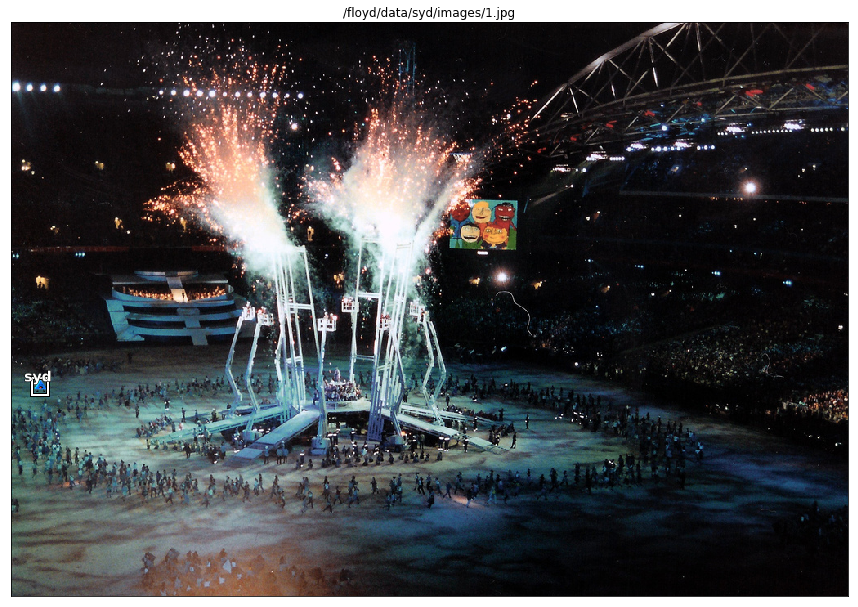

In [3]:
from ipywidgets import interact
from ipywidgets import widgets

# Get the values from csv file
images_list = data['filename'].values
x_min_list = data['xmin'].values
x_max_list = data['xmax'].values
y_min_list = data['ymin'].values
y_max_list = data['ymax'].values

def show_sample(sample_n):
    image_path = os.path.join(IMAGE_DIR,images_list[sample_n-1])
    ymin, xmin, ymax, xmax = y_min_list[sample_n-1], x_min_list[sample_n-1], y_max_list[sample_n-1], x_max_list[sample_n-1]
    im = open_image(image_path)
    ax = show_img(im, figsize=(15,15))
    ax.set_title(image_path)
    b = bb_hw((ymin, xmin, ymax, xmax))
    draw_rect(ax, b)
    draw_text(ax, [xmin-10, ymin-10], 'syd')
    
interact(show_sample, sample_n=widgets.IntSlider(value=1, min=1, max=10, description='Show training sample'));

## Train / Val split

10 samples for training and 2 for evalauting.

In [4]:
#  Train / Val split
train_df = data.iloc[:10]
eval_df = data.iloc[10:]

In [5]:
def class_text_to_int(row_label):
    """Replace the label with an int"""
    if row_label == 'syd': # EDIT WITH YOUR LABELS
        return 1
    else:
        None
        
def split(df, group):
    """For each images, return a data object with all the labels/bbox in the images
    
    e.g.
    
    [data(filename='1.jpg', object=  filename  width  height  class  xmin  ymin  xmax  ymax
     0    1.jpg   2048    1251  syd   706   513   743   562),
     data(filename='10.jpg', object=   filename  width  height  class  xmin  ymin  xmax  ymax
     1    10.jpg   1600     980  syd   715   157   733   181
     19   10.jpg   1600     980  syd   428    83   483   145),
     ...
     data(filename='9.jpg', object=   filename  width  height  class  xmin  ymin  xmax  ymax
     17    9.jpg   1298     951  syd   231   735   261   769)]
     
    """
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
    """
    From data group object to TFRecord file
    
    Note: we are handling JPG data format and bbox labels. 
    If you need to work on PNG data with mask or polygon labels, you will have to edit the code a bit.
    """
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size
    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)
    }))
    return tf_example

In [6]:
# Prepare the TFRecord Output
TRAIN_RECORD_FILE = os.path.join(OUTPUT, 'train.tfrecord')
EVAL_RECORD_FILE = os.path.join(OUTPUT, 'eval.tfrecord')

# TRAIN TFRecord
writer = tf.python_io.TFRecordWriter(path=TRAIN_RECORD_FILE)
path_to_images = os.path.join(os.getcwd(), IMAGE_DIR)

# From CSV to TFRecord
grouped = split(train_df, 'filename')
for group in tqdm(grouped):
    tf_example = create_tf_example(group, path_to_images)
    writer.write(tf_example.SerializeToString())
writer.close()

# EVAL TFRecord
writer = tf.python_io.TFRecordWriter(path=EVAL_RECORD_FILE)
path_to_images = os.path.join(os.getcwd(), IMAGE_DIR)

# From CSV to TFRecord
grouped = split(eval_df, 'filename')
for group in tqdm(grouped):
    tf_example = create_tf_example(group, path_to_images)
    writer.write(tf_example.SerializeToString())
writer.close()

print('Successfully created the TFRecords: {}'.format(OUTPUT))

100%|██████████| 2/2 [00:00<00:00, 197.13it/s]

Successfully created the TFRecords: /floyd/code/tfrecords_data


Great, we have now converted the dataset into TFRecord format! In the next step we will train a pretrained model for finding Syd. Let's jump into `1_training` notebook.